# # 🌿 **  EthnoMed:AI-Powered Mediterranean_Plants Advisor **

# 1. Introduction & Problem Statement

The Challenge: Traditional medicinal knowledge, a cornerstone of cultural heritage and potential source for modern health solutions, is often locked in unstructured formats or oral traditions. Data collected on 257 Mediterranean_Plants represents such invaluable knowledge, but its accessibility and analytical potential are limited in raw form. This risks knowledge loss and hinders alignment with the WHO's goal of integrating traditional medicine effectively.


# **Our Solution:** EthnoMed  leverages cutting-edge Generative AI to transform this dataset into a dynamic, interactive knowledge base. We build an AI-powered Advisor  that allows users to query, analyze, and understand Mediterranean_Plants in a structured and grounded manner.


**Importance: This project contributes to:**
1. Cultural Heritage Preservation:** Digitizing and organizing vital traditional knowledge.
2. WHO Strategy Alignment:** Supporting the goals of the Traditional Medicine Strategy (2025–2034).
3. Knowledge Discovery:** Making complex ethnobotanical data searchable and analyzable.
4. Advanced AI Demonstration:** Showcasing RAG, AI Agents, and Prompt Engineering with Gemini.




# 2. 💎 Methodology & AI Capabilities
 We employ a sophisticated AI architecture:
1.  **RAG System (Retrieval-Augmented Generation):**
    *   **Embedding:** Plant data is converted into semantic vectors using `models/embedding-001`.
   *   **Indexing:** These vectors are stored locally and persistently (within this Kaggle session) using **ChromaDB** in `/kaggle/working/`.
    *   **Retrieval:** User queries are embedded, and ChromaDB finds the most relevant plant data via vector similarity search.
   *   **Generation:** The **Gemini 2.0 Flash** model (implemented via `gemini-1.5-flash-latest`) generates answers *only* based on the retrieved, relevant context, ensuring factual grounding.




2.  **AI Agents (Task-Specific Functions):**
    *   **Q&A Agent:** Uses the RAG pipeline to answer natural language questions.
    *   **Extraction Agent:** Parses unstructured 'Folk Uses' text into structured JSON (ailments, actions, categories).
    *   **Generation Agent:** Creates summaries and informational usage descriptions (with disclaimers) for specific plants.


3.  **Prompt Engineering (Command Engineering):**
     *   Each AI Agent relies on carefully crafted prompts. These instructions guide the Gemini model, define expected output formats (e.g., JSON), enforce constraints (e.g., using only retrieved context, adding disclaimers), and optimize for accuracy and relevance using the target gemini-1.5-flash-latest capabilities 


# 3. 🔧 Setup and Configuration

Install libraries, configure Google API Key (from Kaggle Secrets), initialize Gemini models, and set up the persistent ChromaDB client.


In [58]:
# Install necessary libraries
!pip install -q google-generativeai pandas openpyxl chromadb scikit-learn tqdm

import pandas as pd
import google.generativeai as genai
import chromadb # Vector Store
import json
import os
import re
import numpy as np
from tqdm.notebook import tqdm # Progress bars
from kaggle_secrets import UserSecretsClient
import time

In [59]:
# --- Configuration ---

GENERATIVE_MODEL_NAME = 'gemini-1.5-flash-latest'
EMBEDDING_MODEL_NAME = 'models/text-embedding-004'
CHROMA_PATH = "/kaggle/working/ethnomed_chroma_db" # Persistent path
COLLECTION_NAME = "Mediterranean_plants_v1" # Versioning collection name

print(f"Using Generative Model: {GENERATIVE_MODEL_NAME}")
print(f"Using Embedding Model: {EMBEDDING_MODEL_NAME}")
print(f"Using ChromaDB Path: {CHROMA_PATH}")
print(f"Using Chroma Collection: {COLLECTION_NAME}")

# Configure API Key
API_KEY_CONFIGURED = False
try:
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("GOOGLE_API_KEY")
    genai.configure(api_key=api_key)
    print("✅ Google API Key configured successfully.")
    API_KEY_CONFIGURED = True
except Exception as e:
    print(f"⚠️ Warning: Could not get GOOGLE_API_KEY from Kaggle Secrets: {e}")
    api_key = None


Using Generative Model: gemini-1.5-flash-latest
Using Embedding Model: models/text-embedding-004
Using ChromaDB Path: /kaggle/working/ethnomed_chroma_db
Using Chroma Collection: Mediterranean_plants_v1
✅ Google API Key configured successfully.


In [60]:
# --- Model Initialization ---
generative_model = None
# Embedding model accessed via genai.embed_content

if API_KEY_CONFIGURED:
    try:
        generative_model = genai.GenerativeModel(GENERATIVE_MODEL_NAME)
        generative_model.generation_config = genai.GenerationConfig(
            temperature=0.2, # Lower temperature for more factual/grounded responses
            # top_p=0.95,
            # top_k=40,
            # max_output_tokens=1024 # Adjust if needed
            )
        print(f"✅ Initialized Generative Model: {GENERATIVE_MODEL_NAME}")
        print(f"✅ Embedding Model access configured: {EMBEDDING_MODEL_NAME}")
    except Exception as e:
        print(f"🔴 Error initializing Gemini generative model: {e}")
        generative_model = None
else:
    print("🔴 Models not initialized due to missing API key.")



✅ Initialized Generative Model: gemini-1.5-flash-latest
✅ Embedding Model access configured: models/text-embedding-004


In [61]:
# --- ChromaDB Client Initialization ---
chroma_client = None
chroma_collection = None
if API_KEY_CONFIGURED: 
    try:
        # Ensure the directory exists
        os.makedirs(CHROMA_PATH, exist_ok=True)
        chroma_client = chromadb.PersistentClient(path=CHROMA_PATH)
        print(f"✅ ChromaDB Client initialized. Persistent path: {CHROMA_PATH}")

        chroma_collection = chroma_client.get_or_create_collection(
            name=COLLECTION_NAME,
            metadata={"hnsw:space": "cosine"} # Use cosine similarity
        )
        print(f"✅ ChromaDB Collection '{COLLECTION_NAME}' accessed/created.")
        print(f"   Items in collection: {chroma_collection.count()}")
    except Exception as e:
        print(f"🔴 Error initializing ChromaDB: {e}")
        chroma_client = None
        chroma_collection = None
else:
    print("🔴 ChromaDB not initialized (requires API key for potential embedding).")


✅ ChromaDB Client initialized. Persistent path: /kaggle/working/ethnomed_chroma_db
✅ ChromaDB Collection 'Mediterranean_plants_v1' accessed/created.
   Items in collection: 257


# 4.📄 Data Loading and Preparation

In [62]:
# --- Data Loading ---

file_path = '/kaggle/input/mediterranean-plants/Mediterranean_Plants.csv' 

def load_data(file_path):      
    try:
        if file_path.endswith('.csv'): df = pd.read_csv(file_path)
        elif file_path.endswith('.xlsx'): df = pd.read_excel(file_path)
        else: raise ValueError(f"Unsupported file format: {file_path}")
        print(f"✅ Data loaded from {file_path}")

        # Cleaning & Validation
        df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
        required_cols = ['scientific_name','arabic_name','english_name','part_used','cultivation','method_of_use','folk_uses']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols: raise ValueError(f"Dataset missing required columns: {', '.join(missing_cols)}")
        df = df.fillna('N/A')
        # Generate unique ID
        df['plant_id'] = df.index.astype(str)
        print("✅ Data cleaned, validated, 'plant_id' created.")
        return df  
    except Exception as e:
        print(f"🔴 Error loading data: {e}")
        return None

df_plants = load_data(file_path)

if df_plants is not None:
    print(f"\n--- Dataset Loaded: {len(df_plants)} plants ---")
    display(df_plants.head())


✅ Data loaded from /kaggle/input/mediterranean-plants/Mediterranean_Plants.csv
✅ Data cleaned, validated, 'plant_id' created.

--- Dataset Loaded: 257 plants ---


,plant_id,scientific_name,arabic_name,english_name,part_used,cultivation,method_of_use,folk_uses
0,0,Abies cilicica (Antoine & Kotschy) Carrière,الشوح (Shouh),Cilician Fir,Resin,Wild,Topical,An aromatic oil; the resin is used externally ...
1,1,Acanthus syriacus boiss.,أقنثا، مارعويلا (Akensa),Syrian Bear’s Breeches,Leaf,Wild,Infusion,An infusion of the leaves is used externally t...
2,2,Acer syriacum Boiss. & Gaill.,القيقب السوري (Qyqab souri),Syrian Maple,Fruit,Wild,Juice,Sugary maple juice is produced in a primitive ...
3,3,Achillea falcata L.,قيصومة منجلية، قيسون (Qauesoun),Sickle-leaved Yarrow,Root,Wild,Decoction,A decoction of roots is used as diuretic.
4,4,Achillea fragrantissima (Forssk.) Sch. Bip.,ألفية (Alphieh),Fragrant Yarrow,Leaf,Wild,Infusion,An infusion of the leaves is used in the treat...


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plant_id         257 non-null    int64 
 1   Scientific_Name  257 non-null    object
 2   Arabic_Name      257 non-null    object
 3   English_Name     257 non-null    object
 4   Part_Used        257 non-null    object
 5   Cultivation      257 non-null    object
 6   Method_of_Use    257 non-null    object
 7   Folk_Uses        257 non-null    object
dtypes: int64(1), object(7)
memory usage: 16.2+ KB
None


Count of Plants by Method of Use:
Method_of_Use
Decoction           111
Infusion             78
Fresh                25
Juice                12
Topical               6
Cooked                6
Dried                 6
Boiled                5
Topical and Oral      3
Fresh or Dried        3
External              2
Name: count, dtype: int64


Top 5 Most Common Parts Used:
Part

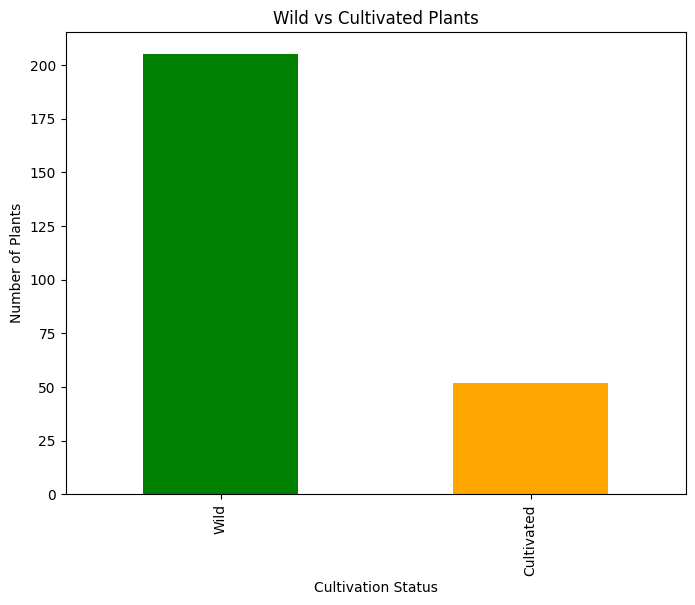

Plants Used for Diabetes:
                                  Scientific_Name  \
2                   Acer syriacum Boiss. & Gaill.   
10                         Agrimonia eupatoria L.   
13                         Alchemilla vulgaris L.   
14                                 Allium cepa L.   
15                                 Allium sativum   
25                               Arctium lappa L.   
29                     Artemisia herba-alba Asso.   
30                 Artemisia verlotiorum Lamotte.   
34                                Avena sativa L.   
36                               Beta vulgaris L.   
45                       Carduus pycnocephalus L.   
52                      Centaurium erythraea Rafn   
54     Cephalaria joppensis (Rchb.) Coult. ex DC.   
61                         Cistus salviifolius L.   
69                          Coriandrum sativum L.   
71                          Crataegus azarolus L.   
75                        Cyclamen persicum Mill.   
79                  

In [63]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv(file_path)

# 1. Basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\n")

# 2. Count of plants by 'Method_of_Use'
print("Count of Plants by Method of Use:")
method_counts = data["Method_of_Use"].value_counts()
print(method_counts)
print("\n")

# 3. Top 5 most common parts used
print("Top 5 Most Common Parts Used:")
part_counts = data["Part_Used"].value_counts().head(5)
print(part_counts)
print("\n")

# 4. Plot a bar chart of Cultivation status
plt.figure(figsize=(8, 6))
data["Cultivation"].value_counts().plot(kind="bar", color=["green", "orange"])
plt.title("Wild vs Cultivated Plants")
plt.xlabel("Cultivation Status")
plt.ylabel("Number of Plants")
plt.show()

# 5. Search for plants with 'diabetes' in Folk_Uses
print("Plants Used for Diabetes:")
diabetes_plants = data[data["Folk_Uses"].str.contains("diabetes", case=False, na=False)]
print(diabetes_plants[["Scientific_Name", "Arabic_Name", "English_Name"]])

# 📦 5. RAG: Embedding and Indexing into ChromaDB

Generate semantic vector embeddings for each plant's data chunk and store them in the persistent ChromaDB collection. Skips if data seems already indexed in the current session

In [64]:
# --- Embedding Generation and ChromaDB Indexing ---
import pandas as pd

def generate_and_index_embeddings_chroma(df, collection, batch_size=100, text_column_name="rag_chunk"):
    """Generates embeddings and adds them to ChromaDB, skipping if counts match."""
    if not API_KEY_CONFIGURED or collection is None or df is None:
        print("🔴 Cannot index: Prerequisites missing (API key, Collection, DataFrame).")
        return False

    expected_count = len(df)
    current_count = collection.count()
    print(f"\n--- Checking ChromaDB Collection '{collection.name}' for Indexing ---")
    print(f"   Dataset size: {expected_count}, Collection size: {current_count}")

    if current_count == expected_count:
        print("✅ Collection count matches dataset size. Assuming data is indexed. Skipping.")
        return True

    print(f"⚠️ Collection size mismatch ({current_count} vs {expected_count}). Proceeding with indexing...")
    # 1. Prepare Data Chunks
    print("   Preparing text chunks for embedding...")
    # Inside generate_and_index_embeddings_chroma, before df.apply
    print("DataFrame Columns:", df.columns.tolist())
    print("Sample Data (first 2 rows):\n", df.head(2))
    df[text_column_name] = df.apply(
        lambda row: f"Plant Name (Scientific): {row['scientific_name']}\n"
                    f"Plant Name (English): {row['english_name']}\n"
                    f"Plant Name (Arabic): {row['arabic_name']}\n"
                    f"Part(s) Used: {row['part_used']}\n"
                    f"Cultivation: {row['cultivation']}\n"
                    f"Method of Use: {row['method_of_use']}\n"
                    f"Folk Uses: {row['folk_uses']}", # Include all key fields
        axis=1
    )
    documents_to_embed = df[text_column_name].tolist()
    ids_to_add = df['plant_id'].tolist()
    metadatas_to_add = df[['scientific_name', 'english_name', 'arabic_name']].to_dict(orient='records')
    print(f"   Prepared {len(documents_to_embed)} documents.")

    # 2. Generate Embeddings in Batches
    all_embeddings = []
    print(f"   Generating embeddings with '{EMBEDDING_MODEL_NAME}' (batch size {batch_size})...")
    try:
        for i in tqdm(range(0, len(documents_to_embed), batch_size), desc="Embedding Batches"):
            batch_docs = documents_to_embed[i:i+batch_size]
            result = genai.embed_content(
                model=EMBEDDING_MODEL_NAME,
                content=batch_docs,
                task_type="RETRIEVAL_DOCUMENT"
            )
            all_embeddings.extend(result['embedding'])
            time.sleep(0.5) # Small delay

        if len(all_embeddings) != len(documents_to_embed):
             raise ValueError("Embedding count mismatch.")
        print(f"   ✅ Generated {len(all_embeddings)} embeddings.")

        # 3. Add to ChromaDB
        print(f"   Adding {len(ids_to_add)} items to ChromaDB collection '{collection.name}'...")
        # Add in batches to ChromaDB as well for potentially large datasets
        chroma_batch_size = 5000 # Chroma can often handle larger batches
        for i in tqdm(range(0, len(ids_to_add), chroma_batch_size), desc="Indexing Batches"):
             collection.add(
                 ids=ids_to_add[i:i+chroma_batch_size],
                 embeddings=all_embeddings[i:i+chroma_batch_size],
                 documents=documents_to_embed[i:i+chroma_batch_size],
                 metadatas=metadatas_to_add[i:i+chroma_batch_size]
             )
        final_count = collection.count()
        print(f"✅ Successfully indexed data. Final collection count: {final_count}")
        if final_count != expected_count:
             print(f"⚠️ Warning: Final count ({final_count}) doesn't match expected ({expected_count}). Check for errors or duplicates.")
        return True

    except Exception as e:
        print(f"🔴 Error during embedding or indexing: {e}")
        return False

# Run the indexing process
indexing_successful = False
if df_plants is not None and chroma_collection is not None:
    indexing_successful = generate_and_index_embeddings_chroma(df_plants, chroma_collection)
else:
    print("🔴 Skipping indexing: Prerequisites missing.")



--- Checking ChromaDB Collection 'Mediterranean_plants_v1' for Indexing ---
   Dataset size: 257, Collection size: 257
✅ Collection count matches dataset size. Assuming data is indexed. Skipping.


# 📦 6. RAG: Retrieval Function (ChromaDB)

# This function queries the ChromaDB collection to find relevant plant data chunks

In [65]:
def find_relevant_plants_chroma(query, collection, top_k=3):
    """Retrieves top_k relevant documents from ChromaDB based on query embedding."""
    if not API_KEY_CONFIGURED or collection is None:
        print("🔴 Cannot retrieve: API key or Chroma Collection missing.")
        return None
    if not indexing_successful:
         print("🔴 Cannot retrieve: Indexing may have failed.")
         return None

    # print(f"   Embedding query for retrieval...") # Less verbose
    try:
        query_embedding_result = genai.embed_content(
            model="models/text-embedding-004",
            content=query,
            task_type="RETRIEVAL_QUERY"
        )
        query_embedding = query_embedding_result['embedding']

        # print(f"   Querying ChromaDB '{collection.name}'...") # Less verbose
        results = collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k,
            include=['documents', 'metadatas', 'distances'] # Get docs, metadata, and distances
        )

        retrieved_documents = results.get('documents', [[]])[0]
        if not retrieved_documents:
            print("   - No relevant documents found in ChromaDB.")
            return []

        # print(f"   + Retrieved {len(retrieved_documents)} documents.") # Less verbose
        return retrieved_documents

    except Exception as e:
        print(f"🔴 Error during ChromaDB retrieval: {e}")
        return None


# 📦 7. AI Agent Capability 1: RAG Q&A Agent (ChromaDB)

**The Q&A Agent uses ChromaDB retrieval to provide grounded answers. **Prompt Engineering** is key here to instruct the model to use *only* the retrieved context.**

In [66]:
def ask_rag_plant_qa_chroma(query):
    """RAG Q&A Agent using ChromaDB retrieval and Gemini 2.0 Flash generation."""
    agent_name = "RAG Q&A Agent (ChromaDB)"
    print(f"\n--- Activating {agent_name} ---")
    print(f"   Query: '{query}'")
    if generative_model is None: return f"{agent_name} Error: Generative model unavailable."
    if chroma_collection is None: return f"{agent_name} Error: ChromaDB collection unavailable."
    if not indexing_successful: return f"{agent_name} Error: Indexing may have failed."

    # 1. Retrieve Context
    print("   1. Retrieving relevant context...")
    relevant_documents = find_relevant_plants_chroma(query, chroma_collection, top_k=3) # Adjust top_k if needed
    if relevant_documents is None: return f"{agent_name} Error: Failed during retrieval."
    if not relevant_documents: return "Based on the available knowledge base, no specific information was found for this query."

    # 2. Engineer Prompt & Augment
    print("   2. Augmenting prompt with retrieved context...")
    context_str = "\n\n---\n".join(relevant_documents)
    prompt = f"""**Role:** You are an Ethnobotany Q&A Agent.
**Knowledge Source:** You have been provided with specific excerpts from a database on  medicinal Mediterranean plants. Your knowledge is STRICTLY limited to this provided context.
**Task:** Answer the user's question accurately and concisely based ONLY on the information within the 'RETRIEVED CONTEXT' section below.

**Constraint Checklist & Reasoning (Internal Monologue - Do NOT output this):**
1.  Is the answer directly present in the context? Yes/No.
2.  If Yes, synthesize the answer clearly from the text.
3.  If No, state that the information is not available *in the provided context*.
4.  AVOID using any external knowledge or making assumptions beyond the context.
5.  Keep the answer focused on the user's specific question.

**RETRIEVED CONTEXT:**
--- START CONTEXT ---
{context_str}
--- END CONTEXT ---

**User Question:** {query}

**Answer:**
"""

    # 3. Generate Answer (using the target generative model)
    print(f"   3. Generating answer using {GENERATIVE_MODEL_NAME}...")
    # Assuming safe_generate_content handles interaction with generative_model
    answer = safe_generate_content(prompt) # Defined in Section 4

    final_answer = answer if answer else f"{agent_name} Error: Failed to generate answer."
    print(f"   4. Agent Response generated.")
    return final_answer


# 📦 RAG Q&A Agent (ChromaDB) Demonstration

In [67]:
# Ensure helper function is defined
def safe_generate_content(prompt, expect_json=False):
    """Safely calls the configured Gemini generative model."""
    if not generative_model: return None
    try:
        response = generative_model.generate_content(prompt)
        response_text = response.text
        if expect_json: return extract_json_from_response(response_text) # Defined later
        else: return response_text
    except Exception as e:
        print(f"🔴 Generative Model Error: {e}")
        # Add more detailed error logging if needed
        # print(f"   Prompt causing error (snippet): {prompt[:500]}...")
        return None

# Define JSON extractor here for use in later agents
def extract_json_from_response(text):
    """Extracts JSON object from text, handling markdown fences."""
    if not text: return None
    match = re.search(r'```json\s*(\{.*?\})\s*```', text, re.DOTALL | re.IGNORECASE)
    if match: json_str = match.group(1)
    else: json_str = text.strip()
    try: return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"🔴 Error: Failed to parse JSON: {e}\n   Snippet: {json_str[:300]}...")
        return None

# Run Q&A Demo
if indexing_successful and generative_model:
    queries = [
        "What are the folk uses of Khubazi (Common Mallow)?",
        "Which plants are wild and used for skin issues?",
        "Tell me about Stinging Nettle.",
        "What is the scientific name for قريص?",
        "Are any plants used for eye health?",
        "Compare uses of Common Mallow and Stinging Nettle for skin." # More complex query
    ]
    for i, q in enumerate(queries):
        answer = ask_rag_plant_qa_chroma(q)
        print(f"\n--- RAG Q&A (ChromaDB) Demo {i+1} ---")
        print(f"Query: {q}")
        print(f"Agent Response:\n{answer}")
        print("-" * 30)
else:
    print("🔴 Cannot run RAG Q&A (ChromaDB) demonstration. Check indexing and model initialization.")



--- Activating RAG Q&A Agent (ChromaDB) ---
   Query: 'What are the folk uses of Khubazi (Common Mallow)?'
   1. Retrieving relevant context...
   2. Augmenting prompt with retrieved context...
   3. Generating answer using gemini-1.5-flash-latest...
   4. Agent Response generated.

--- RAG Q&A (ChromaDB) Demo 1 ---
Query: What are the folk uses of Khubazi (Common Mallow)?
Agent Response:
A decoction of Common Mallow leaves is used for bronchitis, coughs with dry sputum, hoarseness, and as a sedative for minor pain and membrane inflammation.  It's also used for digestive system inflammation, constipation, ulcers, hemorrhoids, urinary infections, and asthenia.  Externally, it treats wounds, sores, insect stings, and hemorrhoids. A flower decoction is used for throat pain and as a gargle.  The leaf mucilage is used in skin creams and in soap and shampoo production.  A dip made from boiled leaves soothes uterine congestion.

------------------------------

--- Activating RAG Q&A Agent (C

# ✨ 8. AI Agent Capability 2: Extraction Agent

This agent uses **Prompt Engineering** to instruct gemini-1.5-flash-latest to extract structured data (JSON) from the 'folk_uses' text of a *specific* plant. RAG is not needed here as the context is the folk use text itself.

In [68]:
def extract_and_classify_uses(plant_name,folk_uses_text):
    """Extraction Agent: Gets structured JSON from folk uses text."""
    agent_name = "Extraction Agent"
    print(f"\n--- Activating {agent_name} for: '{plant_name}' ---", flush=True)
    if not generative_model: return {"error": f"{agent_name} Error: Generative model unavailable."}
    if not folk_uses_text or folk_uses_text == 'N/A':
        print("   - No folk uses description provided.")
        return {"ailments": [], "actions": [], "categories": ["N/A"]}

    # Define categories again for clarity within this agent's scope
    classification_categories = [
        "Respiratory System", "Digestive System", "Skin & Mucous Membranes",
        "Musculoskeletal System", "Nervous System", "Urinary System",
        "Cardiovascular System", "Immune System", "Pain Relief",
        "Wound Healing", "General Wellness/Tonic", "Antiseptic/Anti-infective",
        "Fever Reduction", "Detoxification", "Women's Health", "Men's Health",
        "Oral Health", "Eye Health", "Parasites/Pests", "Veterinary Use", "Other"
    ]

    # Prompt Engineering for JSON Output
    prompt = f"""**Role:** You are an Ethnobotany Extraction Agent.
**Task:** Analyze the provided 'Folk Uses Text' for the plant '{plant_name}' and extract specific information.
**Output Format:** Respond ONLY with a valid JSON object containing the keys "ailments", "actions", and "categories".

**Instructions:**
1.  **ailments:** Create a list of specific ailments, conditions, or symptoms mentioned (e.g., ["cough", "sore throat", "boils"]). Be precise.
2.  **actions:** Create a list of implied therapeutic actions or properties (e.g., ["soothing", "anti-inflammatory", "diuretic"]).
3.  **categories:** Create a list by classifying the primary uses into ONE OR MORE relevant categories from the provided list: {classification_categories}. Choose the most fitting.

**Folk Uses Text:**
--- START TEXT ---
{folk_uses_text}
--- END TEXT ---

**JSON Output:**
"""
    print(f"   1. Sending request to {GENERATIVE_MODEL_NAME} for extraction...")
    extracted_data = safe_generate_content(prompt, expect_json=True)
    print(f"   2. Received response from model.")

    # Validation
    if not extracted_data:
        print(f"   - {agent_name} failed to get or parse JSON response.")
        return {"error": f"{agent_name} Error: Failed to get/parse response"}
    if not isinstance(extracted_data, dict):
         print(f"   - {agent_name} Error: Expected dict but got {type(extracted_data)}.")
         return {"error": f"{agent_name} Error: Invalid response type"}

    # Ensure keys exist and values are lists (basic check)
    valid_data = {}
    expected_keys = ['ailments', 'actions', 'categories']
    for k in expected_keys:
        value = extracted_data.get(k) # Use .get for safer access
        if value is None:
            print(f"   - Warning: Response missing key '{k}'. Defaulting to empty list.")
            valid_data[k] = []
        elif not isinstance(value, list):
             print(f"   - Warning: Expected list for key '{k}', got {type(value)}. Attempting conversion.")
             valid_data[k] = [str(value)] # Convert single value to list
        else:
             valid_data[k] = value # Use the valid list
    print(f"   3. Extraction Agent finished processing.")
    return valid_data
   


# 🧠 Extraction Agent Demonstration

In [69]:
if df_plants is not None and not df_plants.empty and generative_model:
    print("\n--- Extraction Agent Demonstrations ---")
    # Select a few plants for demonstration
    plant_names_to_extract = df_plants['scientific_name'].head(2).tolist() # First 2 plants

    extraction_results = {}
    for name in plant_names_to_extract:
        plant_data_series = df_plants[df_plants['scientific_name'] == name]
        if not plant_data_series.empty:
            plant_data = plant_data_series.iloc[0]
            folk_uses = plant_data['folk_uses']
            print(f"\n--- Analyzing: {name} ---")
            print(f"   Folk Uses: {folk_uses[:150]}...")
            result = extract_and_classify_uses(name, folk_uses)
            extraction_results[name] = result
            print("\n   Extracted Information:")
            print(json.dumps(result, indent=2, ensure_ascii=False)) # Pretty print
            print("-" * 20)
        else:
            print(f"\nCould not find data for {name}")
else:
    print("🔴 Cannot run Extraction demonstration (check data and model init).")



--- Extraction Agent Demonstrations ---

--- Analyzing: Abies cilicica (Antoine & Kotschy) Carrière ---
   Folk Uses: An aromatic oil; the resin is used externally as an antiseptic, it helps in relaxing the muscles, and getting rid of unpleasant odors of the body....

--- Activating Extraction Agent for: 'Abies cilicica (Antoine & Kotschy) Carrière' ---
   1. Sending request to gemini-1.5-flash-latest for extraction...
   2. Received response from model.
   3. Extraction Agent finished processing.

   Extracted Information:
{
  "ailments": [],
  "actions": [
    "antiseptic",
    "muscle relaxant",
    "deodorizing"
  ],
  "categories": [
    "Antiseptic/Anti-infective",
    "Musculoskeletal System",
    "Other"
  ]
}
--------------------

--- Analyzing: Acanthus syriacus boiss. ---
   Folk Uses: An infusion of the leaves is used externally to ease irritation....

--- Activating Extraction Agent for: 'Acanthus syriacus boiss.' ---
   1. Sending request to gemini-1.5-flash-latest for e

# ✨ 9. AI Agent Capability 3: Generation Agent

**This agent uses **Prompt Engineering** with gemini-1.5-flash-latest to generate human-readable summaries and informational usage descriptions, ensuring crucial disclaimers are included**

In [70]:
def generate_plant_summary(plant_series, structured_uses=None):
    """Generation Agent: Creates a concise summary for a plant."""
    agent_name = "Generation Agent (Summary)"
    plant_name = plant_series['scientific_name']
    print(f"\n--- Activating {agent_name} for: '{plant_name}' ---")
    if not generative_model: return f"{agent_name} Error: Model unavailable."

    uses_context = f"Raw Folk Uses: {plant_series['folk_uses'][:200]}..."
    # Use structured info if valid and available
    if structured_uses and isinstance(structured_uses.get('categories'), list) and \
       not any("Error" in cat for cat in structured_uses.get('categories', [])):
        uses_context = (f"AI analysis suggests uses related to: {', '.join(structured_uses['categories'])}. "
                        f"Ailments mentioned: {', '.join(structured_uses.get('ailments',[]))}.")

    # Prompt Engineering for Summary
    prompt = f"""**Role:** You are an Ethnobotany Generation Agent creating a brief summary.
**Task:** Generate a concise summary (3-5 sentences) for the  medicinal plant below, based ONLY on the provided data.
**Audience:** General informational.
**Constraints:** Be factual, neutral. Do NOT add external knowledge. Highlight key identifiers and uses mentioned.

**Plant Data:**
--- START DATA ---
Scientific Name: {plant_series['scientific_name']}
English Name: {plant_series['english_name']}
Arabic Name: {plant_series['arabic_name']}
Part(s) Used: {plant_series['part_used']}
Cultivation: {plant_series['cultivation']}
Method of Use: {plant_series['method_of_use']}
Uses Info: {uses_context}
--- END DATA ---

**Generated Summary:**
"""
    print(f"   1. Sending request to {GENERATIVE_MODEL_NAME} for summary...")
    summary = safe_generate_content(prompt)
    print(f"   2. Summary received.")
    return summary if summary else f"{agent_name} Error: Failed to generate summary."


def generate_usage_instructions(plant_series, structured_uses=None):
    """Generation Agent: Creates informational usage description with disclaimer."""
    agent_name = "Generation Agent (Usage Info)"
    plant_name = plant_series['scientific_name']
    print(f"\n--- Activating {agent_name} for: '{plant_name}' ---")
    if not generative_model: return f"{agent_name} Error: Model unavailable."

    primary_category = "General Use"
    if structured_uses and isinstance(structured_uses.get('categories'), list) and \
        structured_uses.get('categories') and \
        not any(err in str(cat) for cat in structured_uses.get('categories', []) for err in ["Error", "N/A"]):
        #not any(err in str(cat) for err in ["Error", "N/A"]) :
         primary_category = structured_uses['categories'][0]

    method_of_use = plant_series['method_of_use'] if plant_series['method_of_use'] != 'N/A' else "Traditional methods"
    part_used = plant_series['part_used'] if plant_series['part_used'] != 'N/A' else "relevant plant parts"

    # Prompt Engineering for Usage Info with Mandatory Disclaimer
    prompt = f"""**Role:** You are an Ethnobotany Generation Agent creating an informational description of potential traditional use.
**Task:** Describe a plausible traditional preparation method based ONLY on the limited data provided for '{plant_name}'.
**Data Snippet:** Part(s) Used: {part_used}; Method of Use: {method_of_use}; Primary Use Category (if known): {primary_category}.
**Audience:** Informational only, non-medical.

*** MANDATORY INSTRUCTIONS - FOLLOW EXACTLY ***
1.  **START** the response **IMMEDIATELY** with this exact disclaimer:
    "**Disclaimer:** The following describes potential traditional preparation methods based on limited folk data for informational purposes ONLY. It is NOT medical advice. Dosage, efficacy, and safety are not evaluated. Always consult a qualified healthcare professional before using any medicinal plant."
2.  **AFTER** the disclaimer, provide a brief, **general** description of a preparation method consistent with the Part Used and Method of Use (e.g., infusion for leaves, decoction for roots).
3.  **DO NOT** invent specific steps, quantities, timings, or dosages. Keep it very general.
4.  **DO NOT** add any text before the disclaimer or any concluding remarks after the description.

**Generated Description:**
"""
    print(f"   1. Sending request to {GENERATIVE_MODEL_NAME} for usage info...")
    instructions = safe_generate_content(prompt)
    print(f"   2. Usage info received.")
    return instructions if instructions else f"{agent_name} Error: Failed to generate usage info."


# 🧠 Generation Agent Demonstration

In [71]:
if df_plants is not None and not df_plants.empty and generative_model:
    print("\n--- Generation Agent Demonstrations ---")
    # Use results from the extraction demo if available
    if 'extraction_results' not in locals():
         print("⚠️ Extraction results not found from previous step. Generation context will be limited.")
         extraction_results = {} # Ensure it exists
    plant_names_to_generate = df_plants['scientific_name'].head(2).tolist()

    for name in plant_names_to_generate:
        plant_data_series = df_plants[df_plants['scientific_name'] == name]
        if not plant_data_series.empty:
            plant_data = plant_data_series.iloc[0]
            structured_info = extraction_results.get(name) # Get extracted info if available

            print(f"\n--- Generating for: {name} ---")

            # Generate Summary
            summary = generate_plant_summary(plant_data, structured_info)
            print("\nGenerated Summary:")
            print(summary)

            # Generate Usage Info
            instructions = generate_usage_instructions(plant_data, structured_info)
            print("\nGenerated Usage Info (Informational Only):")
            print(instructions)
            print("-" * 30)
        else:
            print(f"\nCould not find data for {name}")
else:
    print("🔴 Cannot run Generation demonstration (check data and model init).")



--- Generation Agent Demonstrations ---

--- Generating for: Abies cilicica (Antoine & Kotschy) Carrière ---

--- Activating Generation Agent (Summary) for: 'Abies cilicica (Antoine & Kotschy) Carrière' ---
   1. Sending request to gemini-1.5-flash-latest for summary...
   2. Summary received.

Generated Summary:
Cilician Fir (*Abies cilicica*), also known as الشوح (Shouh), is a wild-growing plant whose resin is used topically.  Analysis indicates its traditional uses may relate to antiseptic/anti-infective properties and treatment of musculoskeletal issues.  Further uses are categorized as "Other," lacking specific ailment details.  The resin is the only part of the plant currently noted for medicinal use.


--- Activating Generation Agent (Usage Info) for: 'Abies cilicica (Antoine & Kotschy) Carrière' ---
   1. Sending request to gemini-1.5-flash-latest for usage info...
   2. Usage info received.

Generated Usage Info (Informational Only):
**Disclaimer:** The following describes po

# 📝 10. Discussion: RAG, Agents, Prompt Engineering & ChromaDB

**This notebook demonstrated a synergistic approach using key Generative AI techniques:**

*   **RAG with ChromaDB:** Provided efficient, grounded Q&A by retrieving relevant context from a persistent (session-level) vector store. This avoids sending large, irrelevant contexts to the LLM and improves scalability.
*   **AI Agents:** Structuring the code into task-specific agents (Q&A, Extraction, Generation) makes the system modular and easier to manage. Each agent encapsulates specific logic and prompting strategies.
*   **Prompt Engineering:** Was crucial for controlling the behavior of each agent, especially for enforcing constraints like JSON output, disclaimer inclusion, and answering only from retrieved context. Tailoring prompts for the target model (like the efficient Gemini Flash series) is key.


 **Benefits:**
 *   **Grounded & Relevant Answers:** RAG significantly reduces the chance of hallucination in Q&A.
 *   **Efficiency:** Smaller prompts to the LLM, especially for Q&A. Session persistence with ChromaDB avoids redundant embedding.
 *   **Structured Output:** Demonstrated extracting structured data from free text.
 *   **Controlled Generation:** Showcased generating specific text formats with constraints (summaries, usage info with disclaimers).

 **Limitations:** Retrieval quality impacts RAG heavily. Prompt engineering requires iteration. Offline ChromaDB persistence is session-bound in Kaggle. AI outputs still require human oversight, especially concerning traditional medicine
